In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.quantum_info import Statevector, Operator
from qiskit.synthesis.qft import synth_qft_full
import pylatexenc

import numpy as np
# make numpy output look better
np_version = int(np.version.version.split(".")[0])
if np_version >= 2:
    np.set_printoptions(legacy="1.25")

# Oracle for Shor's Algorithm

## Introduction

The goal here is to implement a [Qiskit](https://www.ibm.com/quantum/qiskit) function that takes two positive integers $a$ and $N$ and outputs the oracle

$$
U_a \left| c \right\rangle_1 \left| x \right\rangle = \begin{cases}
  \left| c \right\rangle_1 \left| ax \; \mathrm{mod} N \right\rangle, & \text{if $x=1$ and $y <N$}, \\
  \left| c \right\rangle_1 \left| x \right\rangle, & \text{otherwise.}
\end{cases}
$$

where $n = \lceil \log_2(N) \rceil$.  The construction may only use any number of ancillas, $1$-qubit gates, multi-controlled phase ($MC P$) and $X$ ($MC X$) gates with any number of controls, and the built-in version of the Quantum Fourier Transform (and its inverse). No classical bit and measurements allowed.

We follow Beauregard's [Circuit for Shor’s algorithm using $2n+3$ qubits](https://arxiv.org/pdf/quant-ph/0205095) construction.

## Prerequisites

### State Setter

In order to test the results, we implement a quantum circuit that takes the initial state $\left| 0 \right\rangle_n$ to $\left| a \right\rangle_n$ for given $a$ and $n$.

In [2]:
def binary_digits(a, n):
    """
    Given a and n, returns the first n digits of the binary representation of a.

    INPUTS:
    * a: A positive integer;
    * n: the number of binary digits.

    OUTPUT:
    An array of length n containing the first n binary digits of a, from letft to right.
    """
    return (a % 2 ** np.arange(1, n + 1)) // 2 ** np.arange(n)


def set_state(a, n):
    """
    Returns a circuit in n qubits that takes |0> to |a>.

    INPUTS:
    * a: A positive integer;
    * n: the number of qubits.

    OUTPUT:
    A quantum circuit that takes |0> to |a mod (2**n)> in n-qubits.

    """
    quantum_register = QuantumRegister(size=n, name="x")
    binary_repres = binary_digits(a, n)

    a_setter_circuit = QuantumCircuit(quantum_register, name=f"{a} setter")

    for digit, q in zip(binary_repres, quantum_register):
        if digit:
            a_setter_circuit.x(q)

    return a_setter_circuit

Here is an example:

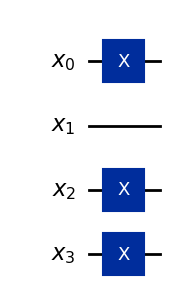

In [3]:
a = 13
n = 4

set_state(a, n).draw("mpl")

### Quantum State to Integer

In many examples below we get some quantum state $\left| \psi \right\rangle_n$ that corresponds to $\left| a \right\rangle_n$ for some integer $a$.  The function below takes such $\left| \psi \right\rangle_n$ and returns $a$.

In [4]:
def state_to_int(q_state):
    """
    Given a quantum state q_state corresponding to |k> for some integer k, returns k.

    INPUT:
    q_state: a quantum state corresponding to |k>.

    OUTPUT:
    The integer k (which we assume exists) such that q_state = |k>.
    """

    # probabilities: should contain a single 1 (and rest are 0)
    probs = np.round(q_state.probabilities(), 4)

    return int(np.sum(probs * np.arange(len(probs))))

Let's test it:

In [5]:
a = 13
n = 4

psi = Statevector(set_state(a, n))
state_to_int(psi) == a

True

### Quantum Fourier Transform


We will use Qiskit's own implementation of the *Quantum Fourier Transform*, [synt_qft_full](https://quantum.cloud.ibm.com/docs/en/api/qiskit/synthesis#synth_qft_full) (imported at the top).  For the inverse, we use `synth_qft_full`'s optional argument `inverse=True`.

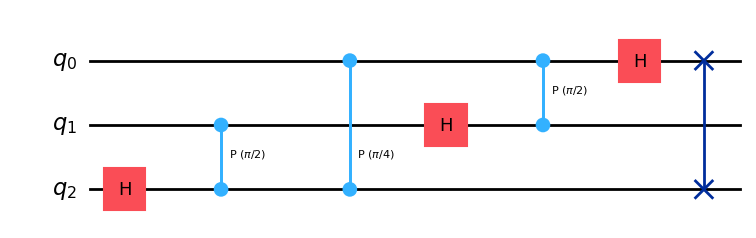

In [6]:
synth_qft_full(num_qubits=3).draw("mpl")

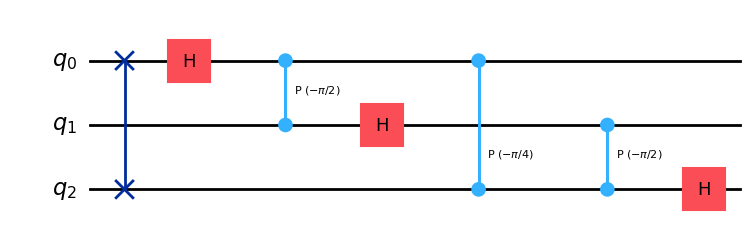

In [7]:
synth_qft_full(num_qubits=3, inverse=True).draw("mpl")

## Draper Adder Gate

Below we implement [Draper's Adder circuit](https://arxiv.org/abs/quant-ph/0008033):

In [8]:
def draper_adder(k, n):
    """
    Given positive integers k and n, returns a quantum circuit that takes |x>_n to
    |x + k mod 2**n>_n.

    INPUTS:
    k: the number to be added (positive integer);
    n: number of qubits.

    OUTPUT:
    A quantum circuit that takes |x>_n to |x + k mod 2**n>_n.
    """
    quantum_register = QuantumRegister(size=n, name="x")
    draper_adder_circuit = QuantumCircuit(quantum_register, name=f"{k} adder")

    draper_adder_circuit.compose(synth_qft_full(n), inplace=True)

    # phaser part
    for i, q in enumerate(reversed(quantum_register)):
        draper_adder_circuit.p(np.pi * k / (2 ** i), q)

    draper_adder_circuit.compose(synth_qft_full(n, inverse=True), inplace=True)

    return draper_adder_circuit

Testing:

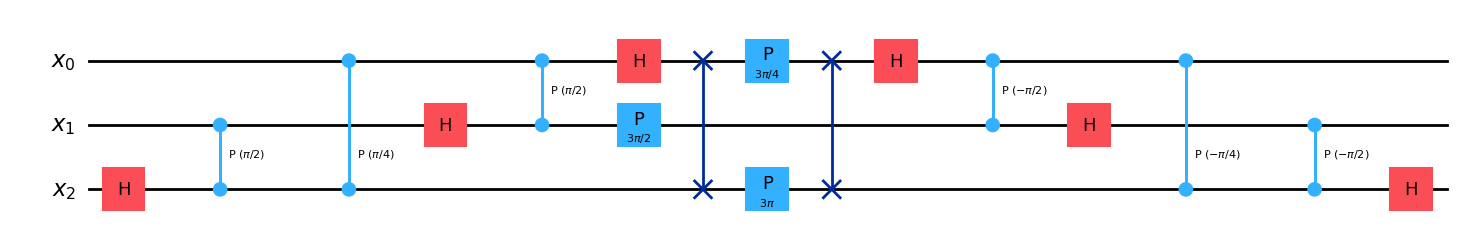

In [9]:
draper_adder(3, 3).draw("mpl")

Let's now test with some numbers.

In [10]:
k, n = 7, 4

psi = Statevector(draper_adder(k, n))
state_to_int(psi) == k

True

Let's test if further, by changing the initial state to a given integer `a`:

In [11]:
a, k, n = 2, 7, 10

psi = Statevector(set_state(a, n).compose(draper_adder(k, n)))
state_to_int(psi) == a + k

True

---

# REMOVE!!!

Alternatively, use qiskit's [DraperQFTAdder](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.DraperQFTAdder):  (**HOW?**)

In [12]:
from qiskit.circuit.library import DraperQFTAdder

In [13]:
def a_b_adder(a, b, n):
    # adder = QuantumCircuit(2 * n)
    # adder.compose(quantum_fourier_transform(2 * n), inplace=True)
    # adder.compose(DraperQFTAdder(n), inplace=True)
    # adder.compose(inverse_quantum_fourier_transform(2 * n), inplace=True)

    quantum_register_a = QuantumRegister(size=n, name="a")
    quantum_register_b = QuantumRegister(size=n, name="b")

    test_adder_a_plus_b = QuantumCircuit(
        quantum_register_a, quantum_register_b, name=f"{a} + {b}"
    )

    a_gate = set_state(a, n).to_gate(label=f"set {a}")
    b_gate = set_state(b, n).to_gate(label=f"set {b}")

    test_adder_a_plus_b.compose(a_gate, quantum_register_a, inplace=True)
    test_adder_a_plus_b.compose(b_gate, quantum_register_b, inplace=True)
    test_adder_a_plus_b.compose(synth_qft_full(n), quantum_register_b, inplace=True)
    test_adder_a_plus_b.compose(DraperQFTAdder(n), inplace=True)
    test_adder_a_plus_b.compose(synth_qft_full(n, inverse=True), quantum_register_b, inplace=True)
    return test_adder_a_plus_b

def test_adder(a, b, n):
    test_adder_a_plus_b = a_b_adder(a, b, n)
    psi = Statevector(test_adder_a_plus_b)
    return np.round(psi.probabilities(), 8)

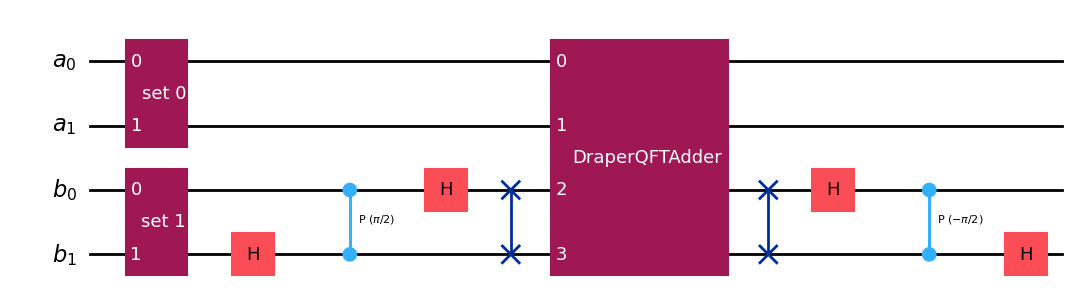

In [14]:
a_b_adder(0, 1, 2).draw("mpl")

In [15]:
test_adder(0, 0, 2)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
test_adder(1, 0, 2)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
test_adder(0, 1, 2)

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
test_adder(2, 0, 2)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
test_adder(1, 1, 2)

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
test_adder(0, 2, 2)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
test_adder(2, 3, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
test_adder(1, 0, 3)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
test_adder(0, 1, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [24]:
test_adder(2, 0, 3)

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
test_adder(1, 1, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
test_adder(0, 2, 3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

---

## Modular Adder Gate

Now, given positive integers $a$ and $N$, we need a quantum circuit such that
$$
\left| c \right\rangle_2 \left| b \right\rangle_{n+1} \left| 0 \right\rangle_1 \mapsto
\begin{cases}
\left| c \right\rangle_2 \left| a + b \; \mathrm{mod} \; N \right\rangle_{n+1} \left| 0 \right\rangle_1 ,& \text{if $\left| c \right\rangle_2 = \left| 11 \right\rangle$}; \\
\left| c \right\rangle_2 \left| b \right\rangle_{n+1} \left| 0 \right\rangle_1, & \text{otherwise.}
\end{cases}
$$
where $n = \lceil \log_2(N) \rceil$.

For future use, we need to control qubits and we will perform computations using $n+1$ qubits instead of $n$, so that we can detect when $a + b \geq N$.  An extra ancilla with one qubit is also used.

To state precisely:

**Lemma:** If $0 < x, N < 2^{n}$, then $x \geq N$ if and only if $(x - N) \; \mathrm{mod} \; 2^{n+1} < 2^n$, i.e., the most significant digit of $(x - N) \; \mathrm{mod} \; 2^{n+1}$ is zero.

*Proof:* If $x \geq N$, then  $(x - N) \; \mathrm{mod} \; 2^{n+1} = x - N$  and $0 \geq x - N < x < 2^n$.

If $x > N$, then $(x - N) \; \mathrm{mod} \; 2^{n+1} = 2^{n+1} - x + N \geq 2^{n+1} - 2^n + 0 = 2^n$. $\square$

Hence if $a, b, N < 2^{n}$, then $a + b \geq N$ if and only if the last qubit of $\left| a+b-N \right\rangle_{n+1}$ is $1$.

Here is the then the process, skipping the two control qubits:

**IMPORTANT:** We assume here that $0 \leq a, b < N$.  This means that $a+b < 2N$, and hence
$$
a+b \; \mathrm{mod} \; N =
\begin{cases}
a + b, & \text{if $a+b<N$};\\
N - (a+b),& \text{if $a+b \geq N$.}
\end{cases}
$$

1) Start with $\left| b \right\rangle_{n+1} \left| 0 \right\rangle_1$.
2) Use an adder gate to the first $n+1$ qubits to get $\left| a+b \right\rangle_{n+1} \left| 0 \right\rangle_1$.
3) Use the inverse of an adder gate to the first $n+1$ qubits to get $\left| a+b - N \right\rangle_{n+1} \left| 0 \right\rangle_1$.
4) With $CX$ gate, with control as the last qubit of $\left| a+b - N \right\rangle_{n+1}$ and target the last qubit, by the lemma above we get
$$
\begin{cases}
\left| a+b - N \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b \geq N$}, \\
\left| a+b-N \right\rangle_{n+1} \left| 1 \right\rangle_1,& \text{if $a+b < N$}.
\end{cases}
$$
5)  Then, with a controlled adder gate, with the last qubit as control and target as the first $n+1$ qubits, we get
$$
\begin{cases}
\left| a+b - N \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b \geq N$}, \\
\left| a+b \right\rangle_{n+1} \left| 1 \right\rangle_1,& \text{if $a+b < N$}.
\end{cases}
$$
(We now just need to return the last qubit to $\left| 0 \right\rangle_1$ if necessary.)
6) With an inverse of an adder gate, we get
$$
\begin{cases}
\left| b - N \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b \geq N$}, \\
\left| b \right\rangle_{n+1} \left| 1 \right\rangle_1,& \text{if $a+b < N$}.
\end{cases}
$$
7) Since $0 \leq b < N$, by our lemma again, we can use a $X$ gate in the qubit before last, followed by a $CX$ gate with the control the last qubit before last and target as the last one, followed by an $X$ gate in the qubit before last, obtaining
$$
\begin{cases}
\left| b - N \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b \geq N$}, \\
\left| b \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b < N$}.
\end{cases}
$$
8) Finally, we add another adder gate, obtaining
$$
\begin{cases}
\left| a+b - N \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b \geq N$}, \\
\left| a+b \right\rangle_{n+1} \left| 0 \right\rangle_1,& \text{if $a+b < N$}.
\end{cases}
$$


The function below implements this:

In [27]:
def modular_adder(a, N):
    """
    Given positive integers a and N, with a < N, given a controlled modular (with two
    control qubits) adder gate that takes
       |11> |b>_n+1 |0>_1  to  |11> |a + b mod N>_n+1 |0>_1,
    where n = ceil(log2(N)).

    INPUTS:
    * a: the number to be added;
    * N: the modulus.

    OUTPUT:
    A controlled modular (with two control qubits) adder gate that takes
       |11> |b>_n+1 |0>_1  to  |11> |a + b mod N>_n+1 |0>_1,
    where n = ceil(log2(N)).
    """

    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=2, name="c")
    quantum_register = QuantumRegister(size=n + 1, name="x")  # note the "+1"!
    last_register = QuantumRegister(size=1, name="l")

    mod_adder_circ = QuantumCircuit(
        control_register, quantum_register, last_register, name=f"Add({a})_Mod({N})"
    )

    # create the gates to be used
    # add and subtract a
    add_a_gate = draper_adder(a, n + 1).to_gate(label=f"add_{a}")
    add_a_gate_inv = draper_adder(a, n + 1).inverse().to_gate(label=f"sub_{a}")
    # controlled versions
    c_add_a_gate = add_a_gate.control(2)
    c_add_a_gate_inv = add_a_gate_inv.control(2)

    # add and subtract N
    add_N_gate = draper_adder(N, n + 1).to_gate(label=f"add_{N}")
    add_N_gate_inv = draper_adder(N, n + 1).inverse().to_gate(label=f"sub_{N}")
    # controlled version
    c_add_N_gate = add_N_gate.control(1)

    mod_adder_circ.compose(c_add_a_gate, range(n + 3), inplace=True)
    mod_adder_circ.compose(add_N_gate_inv, quantum_register, inplace=True)
    mod_adder_circ.cx(-2, -1)
    mod_adder_circ.compose(c_add_N_gate, [-1] + list(range(2, n + 3)), inplace=True)
    mod_adder_circ.compose(c_add_a_gate_inv, range(n + 3), inplace=True)
    mod_adder_circ.x(-2)
    mod_adder_circ.cx(-2, -1)
    mod_adder_circ.x(-2)
    mod_adder_circ.compose(c_add_a_gate, range(n + 3), inplace=True)

    return mod_adder_circ

Here is a picture:

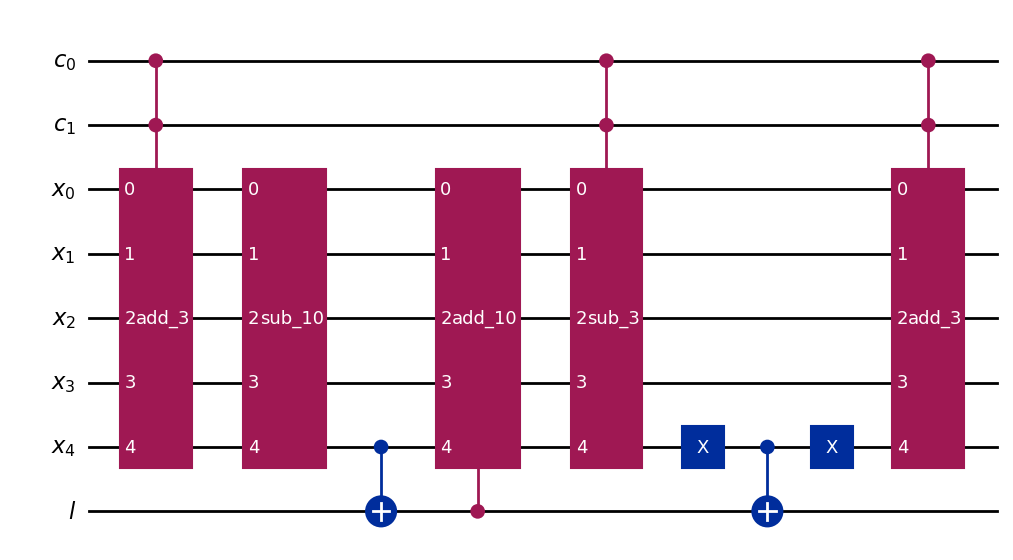

In [28]:
a, N = 3, 10

modular_adder(a, N).draw("mpl")

Let's test it:

In [29]:
a, N = 3, 10

n = int(np.ceil(np.log2(N)))

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage

mod_adder.compose(modular_adder(a, N), inplace=True)
psi = Statevector(mod_adder)

Since we've set $(c_0, c_1) = (1, 1)$ to run, we need to subtract $1 + 1 \cdot 2 = 3$ and divide by $2^2$ to get the result.

In [30]:
(state_to_int(psi) - 3) // 4 == a

True

Now, let's add another number:

In [31]:
a = 5
N = 10
n = int(np.ceil(np.log2(N)))

b = 7

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage
mod_adder.compose(set_state(b, n + 1), quantum_register, inplace=True)

mod_adder.compose(modular_adder(a, N), inplace=True)

psi = Statevector(mod_adder)
(state_to_int(psi) - 3) // 4 == (a + b) % N

True

**IMPORTANT:**  As observed above, we must have $0 \leq a, b < N$:

In [32]:
a = 11
N = 10
n = int(np.ceil(np.log2(N)))

b = 12

control_register = QuantumRegister(size=2, name="c")
quantum_register = QuantumRegister(size=n + 1, name="x")
last_register = QuantumRegister(size=1, name="l")

mod_adder = QuantumCircuit(control_register, quantum_register, last_register)

mod_adder.x([0, 1])  # make sure it runs at this stage
mod_adder.compose(set_state(b, n + 1), quantum_register, inplace=True)

mod_adder.compose(modular_adder(a, N), inplace=True)

psi = Statevector(mod_adder)
(state_to_int(psi) - 3) // 4 == (a + b) % N

False

In [33]:
(state_to_int(psi) - 3) // 4, (a + b) % N

(45, 3)

## The Controlled Multiplier

We now need a controlled modular multiplier:
$$
\left| c \right\rangle_1 \left| x \right\rangle_n \left| b \right\rangle_{n+1} \mapsto
\begin{cases}
\left| c \right\rangle_1 \left| x \right\rangle_n \left| b + ax \; \mathrm{mod} \; N \right\rangle_{n+1},& \text{if $c=1$}; \\
\left| c \right\rangle_1 \left| x \right\rangle_n \left| b \right\rangle_{n+1}, & \text{otherwise.}
\end{cases}
$$

The idea is to use the modular adder.  If $x = \sum_{i=0}^{n-1} x_i 2^i$, then $ax = \sum_{i=0}^{n-1} a x_i 2^i$.  When $x_i=0$, we can skip the term, and when $x_i$ we add $a$ to the previous value $2^i$ times, always reducing modulo $N$, with our modular adder.

Here is the implementation:

In [34]:
def modular_mult(a, N):
    """
    Given positive integers a and N, with a < N, given a controlled modular multiplier
    gate that takes
       |1> |x>_n _|b>_n+1   to  |1> |x>_n _|ax + b mod N>_n+1,
    where n = ceil(log2(N)).

    INPUTS:
    * a: the number to be multtiplied;
    * N: the modulus.

    OUTPUT:
    A controlled modular multiplier gate that takes
       |1> |x>_n _|b>_n+1   to  |1> |x>_n _|ax + b mod N>_n+1,
    where n = ceil(log2(N)).
    """

    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    adder_register = QuantumRegister(size=n + 2, name="b")

    mod_mult_circ = QuantumCircuit(
        control_register, quantum_register, adder_register, name=f"Mult({a})_Mod({N})"
    )

    # below we will use modular add gates with a * (2 **i); these need to be reduced
    # first!!!
    for i in range(n):
        mod_mult_circ.compose(
            modular_adder((a * 2**i) % N, N),  # REDUCE!!
            [0] + [i + 1] + list(range(n + 1, 2 * n + 3)),
            inplace=True,
        )

    return mod_mult_circ

Let's test it, as usual:

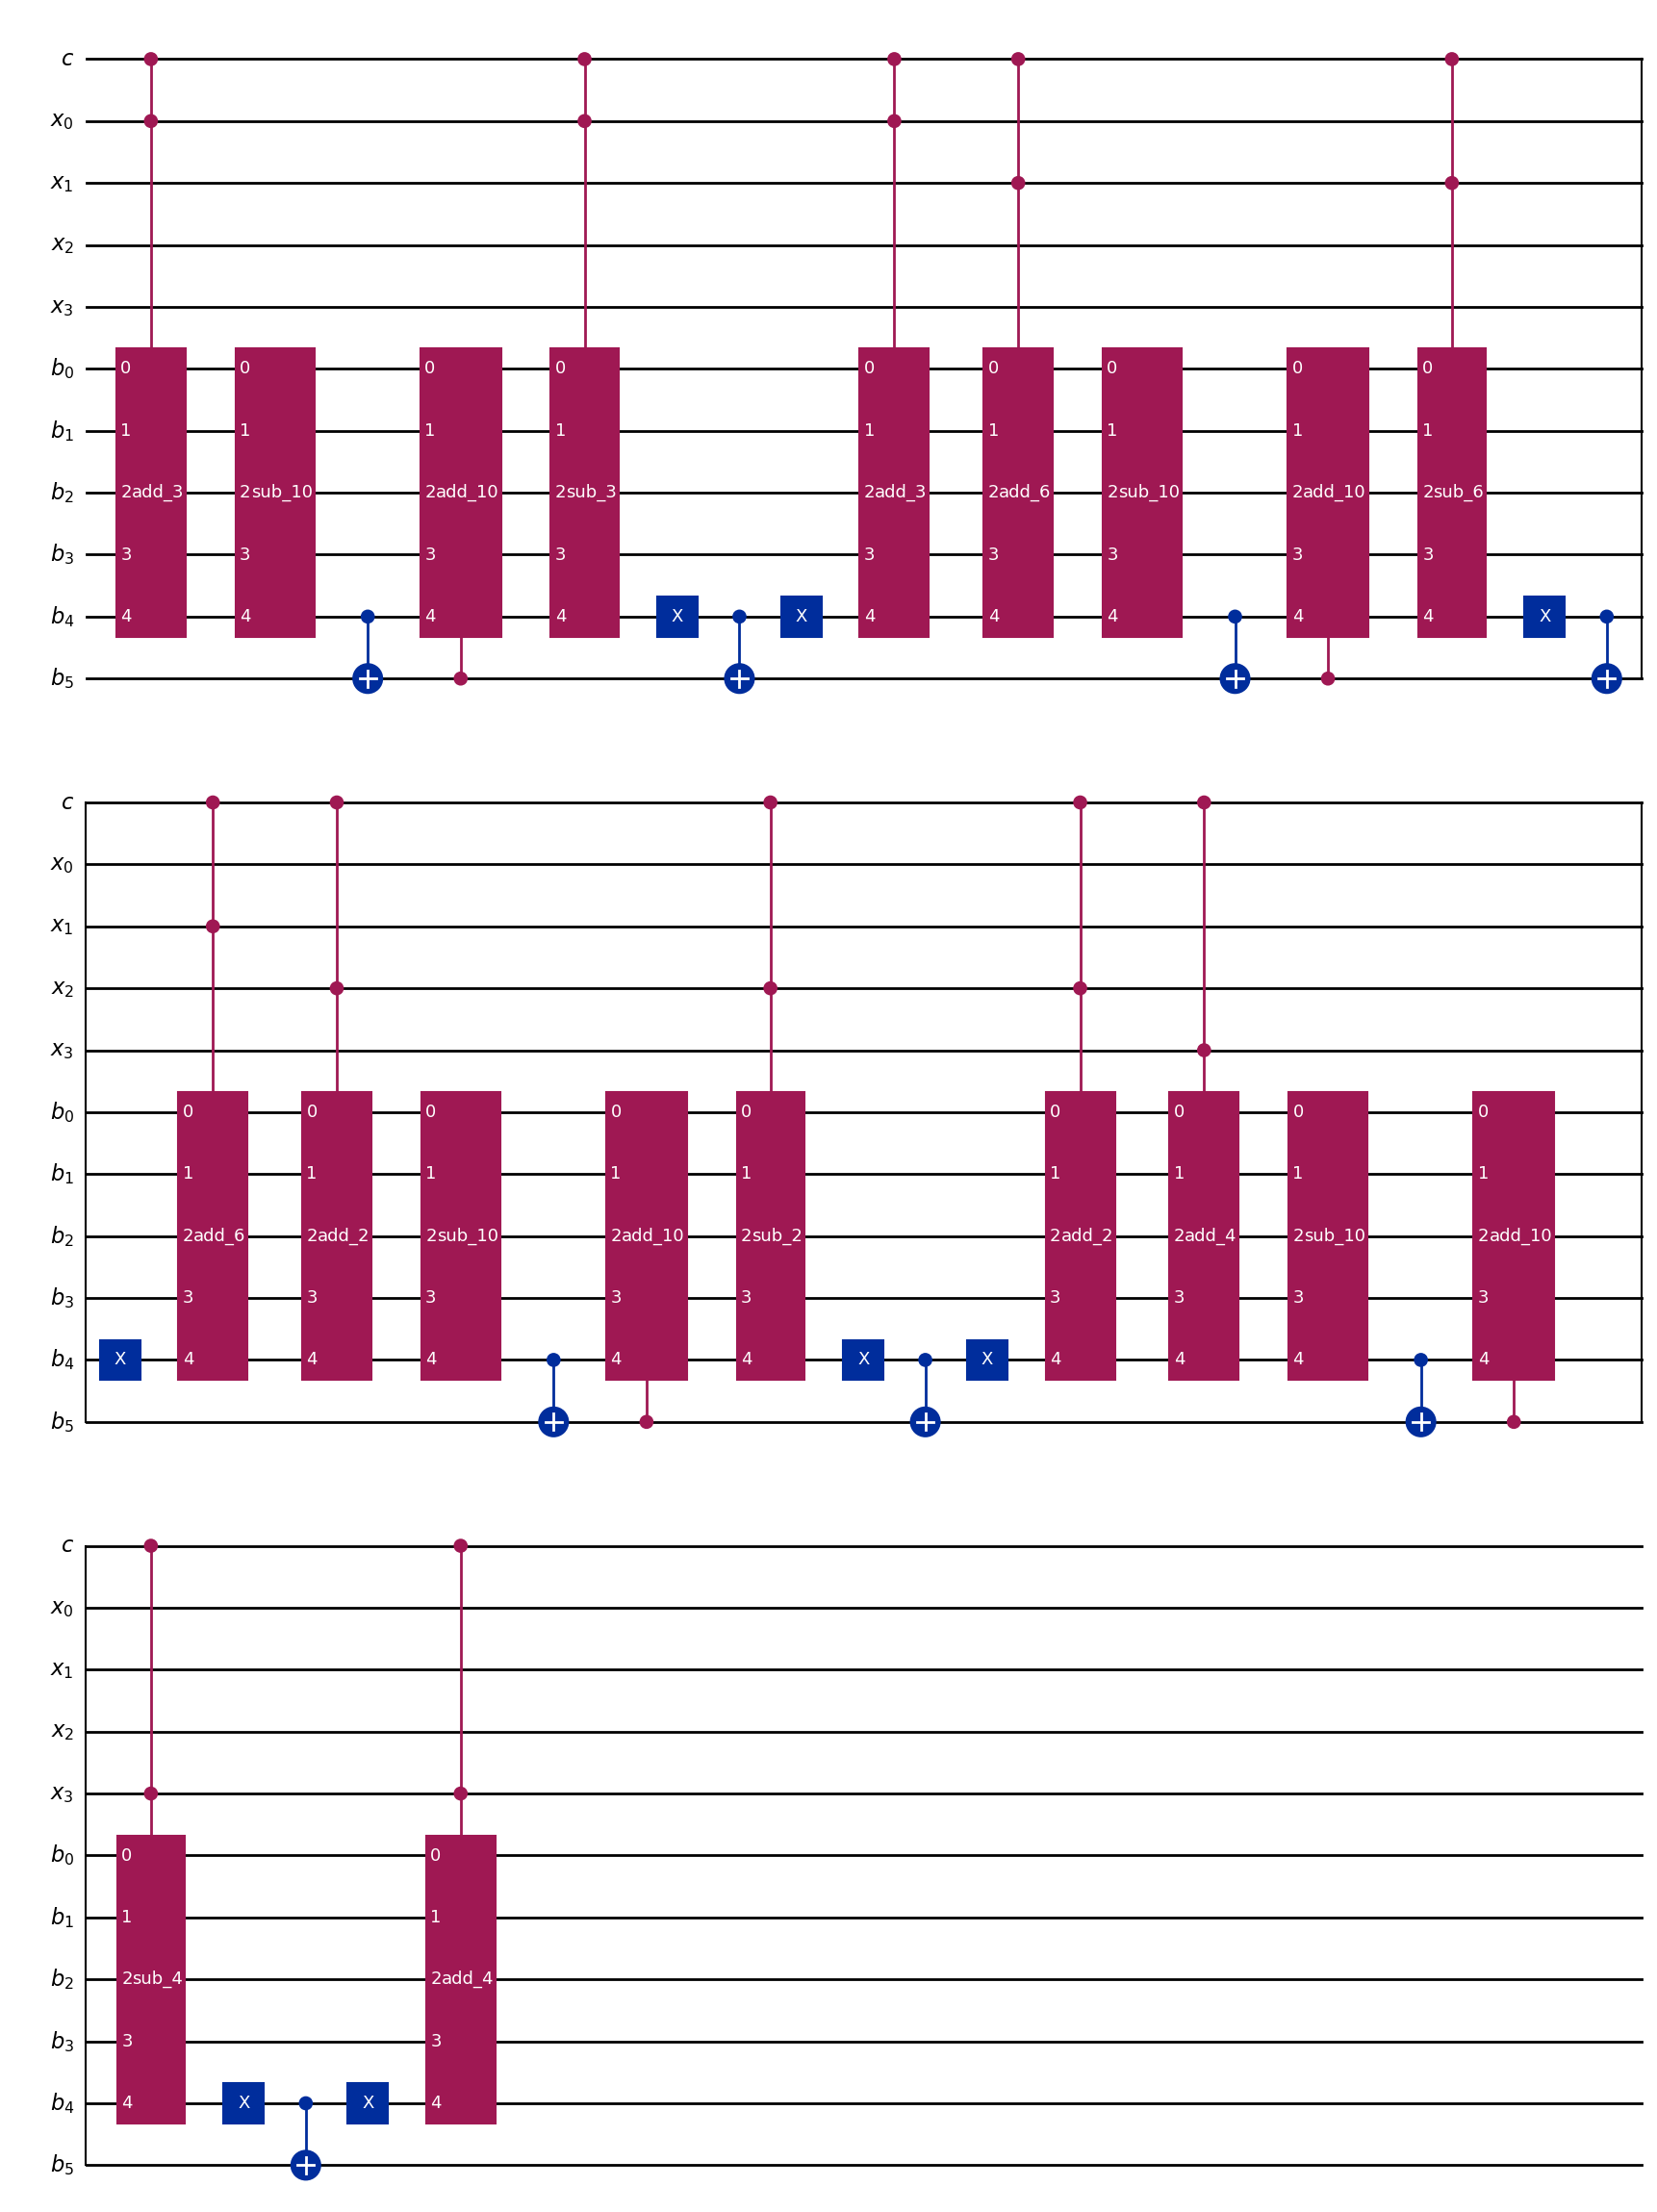

In [35]:
a = 3
N = 10
modular_mult(a, N).draw("mpl")

Test with control equal to $1$:

In [36]:
a = 4
N = 15

b = 5
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_state(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_state(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)

Since the result is in the last $n+1$ qubits (after other $n+1$ qubits), we need to subtract $1 - 2x$ and divide by $2^{n+1}$:

In [37]:
(state_to_int(psi) - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

True

Now, let's test it with control equal to zero (just in case):

In [38]:
# CONTROL IS ZERO!!!!!!

a = 4
N = 15

b = 7
x = 10

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

# mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_state(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_state(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)
state_to_int(psi) == x * 2 + b * (2 ** (n + 1))

True

### Without Reducing $a \cdot 2^k$

Here is a version that does not use classical computation of $a \cdot 2^k$ modulo $N$:

In [39]:
def modular_mult_2(a, N):
    """
    Given positive integers a and N, with a < N, given a controlled modular multiplier
    gate that takes
       |1> |x>_n _|b>_n+1   to  |1> |x>_n _|ax + b mod N>_n+1,
    where n = ceil(log2(N)).

    INPUTS:
    * a: the number to be multtiplied;
    * N: the modulus.

    OUTPUT:
    A controlled modular multiplier gate that takes
       |1> |x>_n _|b>_n+1   to  |1> |x>_n _|ax + b mod N>_n+1,
    where n = ceil(log2(N)).
    """
    n = int(np.ceil(np.log2(N)))

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    adder_register = QuantumRegister(size=n + 2, name="b")

    mod_mult_circ = QuantumCircuit(
        control_register, quantum_register, adder_register, name=f"Mult({a})_Mod({N})"
    )

    # this will contain adder gates for a * 2**i
    add_power_2 = modular_adder(a, N)

    for i in range(n):
        mod_mult_circ.compose(
            add_power_2,
            [0] + [i + 1] + list(range(n + 1, 2 * n + 3)),
            inplace=True,
        )
        add_power_2.compose(add_power_2, inplace=True)

    return mod_mult_circ

Let's test it also:

In [40]:
a = 4
N = 15

b = 5
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
last_register = QuantumRegister(size=n + 2, name="b")

mod_multiplier = QuantumCircuit(control_register, quantum_register, last_register)

mod_multiplier.x(0)  # make sure it runs at this stage
mod_multiplier.compose(set_state(x, n), quantum_register, inplace=True)

if b != 0:
    mod_multiplier.compose(set_state(b, n + 2), last_register, inplace=True)

mod_multiplier.compose(modular_mult(a, N), inplace=True)

psi = Statevector(mod_multiplier)
(state_to_int(psi) - (1 + 2 * x)) // 2 ** (n + 1) == (b + a * x) % N

True

## Oracle for Shor's Algorithm

We finally can construct the oracle for Shor's algorithm, as described in the introduction.

We also need to implement our own version of controlled swap:

In [41]:
def cswap():
    """
    Returns a controlled swap circuit.
    """
    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=2, name="x")

    swap_circ = QuantumCircuit(control_register, quantum_register, name="swap")

    swap_circ.cx(2, 1)
    swap_circ.ccx(0, 1, 2)
    swap_circ.cx(2, 1)

    return swap_circ

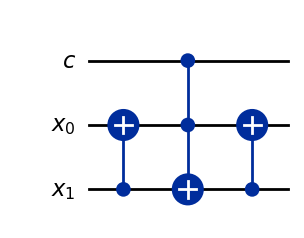

In [42]:
cswap().draw("mpl")

Here is an implementation that does not require to compute inverses modulo $N$, but leaves garbage in the ancilla.

In [43]:
# garbage in ancilla
def shors_oracle_gate_2(a, N):

    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 3, name="b")

    oracle = QuantumCircuit(
        control_register, quantum_register, ancilla, name=f"Mult({a})_Mod({N})"
    )

    # controlled add/subtract N
    add_N_gate = draper_adder(N, n + 1).to_gate(label=f"add_{N}").control(1)
    add_N_gate_inv = draper_adder(N, n + 1).inverse().to_gate(label=f"sub_{N}").control(1)

    # deal with case when x > N
    # using the ancilla before last as extra precision for addition and
    # last ancilla to keep track if need to disable control
    oracle.compose(add_N_gate_inv, [0] + list(range(1, n+1)) + [2 * n + 2], inplace=True)
    oracle.cx(0, 2 * n + 2)
    oracle.ccx(0, 2 * n + 2, 2 * n + 3)
    oracle.cx(0, 2 * n + 2)
    oracle.compose(add_N_gate, [0] + list(range(1, n+1)) + [2 * n + 2], inplace=True)
    oracle.cx(2 * n + 3, 0)
    
    mod_mult_a_N = modular_mult(a, N)

    oracle.compose(mod_mult_a_N, inplace=True)
    for i in range(n):
        # oracle.cswap(0, i + 1, n + i + 1)
        oracle.compose(cswap(), [0, i + 1, n + i + 1], inplace=True)

    # reset the control qubit if necessary
    oracle.cx(2 * n + 3, 0)

    return oracle

In [44]:
def test_oracle(a, N, c, x):
    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 3, name="b")
    
    oracle = QuantumCircuit(control_register, quantum_register, ancilla)
    
    if c != 0:
     oracle.x(0)
    
    oracle.compose(set_state(x, n), quantum_register, inplace=True)
    
    oracle.compose(shors_oracle_gate_2(a, N), inplace=True)
    
    psi = Statevector(oracle)
    
    # drop the ancillas
    res = state_to_int(psi) % 2 ** (n + 1)
    
    if c == 0 or (x >= N):
        return res == c + 2 * x

    return print((res - 1) // 2 == (a * x) % N)

In [45]:
a = 7
N = 15

c = 1
x = 10

test_oracle(a, N, c, x)

True


In [46]:
a = 7
N = 15

c = 0
x = 10

test_oracle(a, N, c, x)

True

In [47]:
a = 7
N = 15

c = 1
x = 10

test_oracle(a, N, c, x)

True


In [48]:
a = 7
N = 20

c = 1
x = 22

test_oracle(a, N, c, x)

True

---

If we don't want garbage in our ancilla, we need to be able to invert integers modulo $N$.  Here is an implementation of the extended Euclidean algorithm:

In [49]:
def modular_inverse(a, N):
    """
    Given integers a and N, with N>0, retrurns the inverse of a
    modulo N.

    INPUTS:
    * a: an integer to be inverted;
    * N: the modulus.

    OUTPUT:
    The inverse of a modulo N.
    """
    x, y, u1, u2 = a, N, 1, 0
    r = x % y
    while r != 0:
        q, r = divmod(x, y)
        x, y, u1, u2 = y, r, u2, (u1 - q * u2)

    if x != 1:
        raise ValueError(f"GCD of {a} and {N} is {x}, not 1.  No inverse exists.")

    return u1 % N

In [50]:
def shors_oracle_gate(a, N):

    n = int(np.floor(np.log2(N)) + 1)

    control_register = QuantumRegister(size=1, name="c")
    quantum_register = QuantumRegister(size=n, name="x")
    ancilla = QuantumRegister(size=n + 2, name="b")

    oracle = QuantumCircuit(
        control_register, quantum_register, ancilla, name=f"Mult({a})_Mod({N})"
    )

    mod_mult_a_N = modular_mult(a, N)

    oracle.compose(mod_mult_a_N, inplace=True)
    for i in range(n):
        # oracle.cswap(0, i + 1, n + i + 1)
        oracle.compose(cswap(), [0, i + 1, n + i + 1], inplace=True)

    # is this necessary?  we can leave garbage in the ancilla, right?
    # b = modular_inverse(a, N)
    # inv_mod_mult_a_N = modular_mult(N - b, N)
    inv_mod_mult_a_N = modular_mult(N - a, N).inverse()

    oracle.compose(inv_mod_mult_a_N, inplace=True)

    return oracle

Test:

In [51]:
a = 7
N = 15

c = 1
x = 3

n = int(np.floor(np.log2(N)) + 1)

control_register = QuantumRegister(size=1, name="c")
quantum_register = QuantumRegister(size=n, name="x")
ancilla = QuantumRegister(size=n + 2, name="b")

oracle = QuantumCircuit(control_register, quantum_register, ancilla)

if c != 0:
 oracle.x(0)

oracle.compose(set_state(x, n), quantum_register, inplace=True)

oracle.compose(shors_oracle_gate(a, N), inplace=True)

psi = Statevector(oracle)
probs = np.round(psi.probabilities(), 4)
res = np.sum(probs * np.arange(len(probs)))

if c == 0:
    print(res == 2 * x)
else:
    print((res - 1) // 2 == (a * x) % N)

True
